
# Identificación de Neumonía – versión resumida
Pipeline compacto para: 1) preprocesar rayos X, 2) extraer features fijados, 3) entrenar (árbol, regresión logística, KNN) con opción de usar subconjunto, 4) exportar modelos y artefacto SageMaker (`model.tar.gz`).



## Configuración rápida
- Cambia `DATA_DIR` a la ruta de tus carpetas `train/NORMAL` y `train/PNEUMONIA`.
- `LIMIT_PER_CLASS` permite usar solo parte del dataset para entrenar más rápido (o `None` para todo).
- `USE_MULTI_CLASS` activa 4 clases (0 normal, 1 neumonía, 2 viral, 3 bacteriana) usando el nombre del archivo.
- `FEATURE_COLUMNS` son las variables relevantes usadas en entrenamiento e inferencia.



## Flujo de reentrenamiento y exportación reproducible
1. Prepara un entorno limpio (venv/conda) e instala dependencias base (`numpy`, `pandas`, `scikit-learn`, `opencv-python` o `Pillow`, `matplotlib`, `joblib`). Alinea la versión de Python con la que usarás en `deploy.ipynb`.
2. Confirma la estructura de datos: `train/NORMAL`, `train/PNEUMONIA` (y opcionalmente clases viral/bacteriana). Ajusta `DATA_DIR` y `LIMIT_PER_CLASS` antes de correr.
3. Preprocesa y normaliza imágenes (tamaño, escala de grises, histogramas) y genera features fijadas para mantener inferencia ligera.
4. Divide en train/valid/test con semilla fija para reproducibilidad y balancea si es necesario.
5. Entrena y compara los modelos del script (árbol de decisión, regresión logística, KNN) con los mismos hiperparámetros; guarda métricas por clase (precision, recall, f1, support).
6. Serializa el modelo y las transformaciones previas (`joblib.dump`) y genera `model.tar.gz` listo para SageMaker.
7. Ejecuta la celda de registro de dependencias para crear `requirements_neumonia.txt`; súbelo junto al artefacto al bucket S3 y utilízalo en el contenedor de despliegue para evitar errores de versión.


In [ ]:
import os, json, tarfile
import numpy as np
import pandas as pd
import cv2
from skimage.measure import label, regionprops
from skimage import morphology
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import joblib
from pathlib import Path

BASE_DATA_DIR = Path(os.environ.get("NEUMONIA_DATA_DIR", "Proyecto_Servidores/modelos/code/data_neumonia"))  # datos locales en SageMaker
OUTPUT_DIR = "./modelos_exportados"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def resolve_data_dir(base: Path) -> Path:
    """Devuelve la carpeta que contiene train/test/val. Prueba varias rutas comunes."""
    candidates = [base, base / "chest_xray", Path("modelos/code/data_neumonia"), Path("modelos/code/data_neumonia/chest_xray"), Path("Proyecto_Servidores/modelos/code/data_neumonia"), Path("Proyecto_Servidores/modelos/code/data_neumonia/chest_xray")]
    tried = []
    for cand in candidates:
        tried.append(str(cand))
        if (cand / "train").exists() and (cand / "test").exists():
            return cand
    raise FileNotFoundError(f"No se encontró train/test en ninguna de estas rutas: {tried}")


DATA_DIR = resolve_data_dir(BASE_DATA_DIR)
print(f"Usando DATA_DIR: {DATA_DIR}")

# Usa None para todo el dataset; un entero para limitar por clase y acelerar
LIMIT_NORMAL = 500
LIMIT_PNEUMONIA = 1000
USE_MULTI_CLASS = False  # True: viral/bacteriana (2/3) según nombre de archivo
RANDOM_STATE = 11
FEATURE_COLUMNS = ['hu0', 'hu1', 'hu2', 'hu3', 'hist_mean', 'hist_std', 'hist_kurtosis', 'fourier_mean', 'fourier_std', 'area']


In [ ]:

def round_to_sig_figs(value, sig_figs=6):
    if value == 0 or np.isnan(value):
        return 0.0
    return round(value, sig_figs - int(np.floor(np.log10(abs(value)))) - 1)

def mean_non_zero(image):
    nz = image[image > 0]
    return float(np.mean(nz)) if nz.size else 0.0

def adjust_image(image, reference_value=130, tolerance=1, max_iterations=2):
    adjusted = image.copy()
    for _ in range(max_iterations):
        diff = reference_value - mean_non_zero(adjusted)
        if abs(diff) <= tolerance:
            break
        adjusted = np.clip(adjusted + diff, 0, 255).astype(np.uint8)
    return adjusted

def procesar_imagen(img, umbral=130, num_areas=2, kernel_size=(7, 7)):
    img = adjust_image(img)
    _, bin_img = cv2.threshold(img, umbral, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones(kernel_size, np.uint8)
    bin_img = cv2.erode(bin_img, kernel, iterations=2)
    labeled = label(bin_img)
    regions = regionprops(labeled)
    mask = np.ones(bin_img.shape, dtype=bool)
    for region in sorted(regions, key=lambda r: r.area, reverse=True)[:num_areas]:
        mask[tuple(zip(*region.coords))] = False
    filtered = bin_img.copy()
    filtered[~mask] = 0
    filtered = cv2.dilate(filtered, kernel, iterations=3)
    return cv2.bitwise_and(filtered, img)


In [ ]:

def extract_features(img):
    feats = {}
    morphology.remove_small_objects(img.astype(bool), min_size=20)
    moments = cv2.moments(img)
    hu = cv2.HuMoments(moments).flatten()
    for i in range(7):
        feats[f"hu{i}"] = round_to_sig_figs(np.sign(hu[i]) * np.log(np.abs(hu[i]) + 1e-10))
    non_zero = img[img > 0]
    feats["avg_intensity"] = round_to_sig_figs(np.mean(non_zero) if non_zero.size else 0)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    feats["hist_mean"] = round_to_sig_figs(np.mean(hist))
    feats["hist_std"] = round_to_sig_figs(np.std(hist))
    feats["hist_skewness"] = round_to_sig_figs(stats.skew(hist))
    feats["hist_kurtosis"] = round_to_sig_figs(stats.kurtosis(hist))
    edges = cv2.Canny(img, 100, 200)
    feats["edge_density"] = round_to_sig_figs(np.sum(edges) / img.size)
    f_shift = np.fft.fftshift(np.fft.fft2(img))
    mag = 20 * np.log(np.abs(f_shift) + 1e-10)
    feats["fourier_mean"] = round_to_sig_figs(np.mean(mag))
    feats["fourier_std"] = round_to_sig_figs(np.std(mag))
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    area = cv2.contourArea(max(contours, key=cv2.contourArea)) if contours else 0.0
    feats["area"] = round_to_sig_figs(area)
    return feats


In [ ]:
def infer_label_from_name(file_path, default_label):
    if not USE_MULTI_CLASS:
        return default_label
    name = os.path.basename(file_path).lower()
    if "virus" in name:
        return 2
    if "bacteria" in name:
        return 3
    return default_label

def process_image(file_path, default_label):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    lbl = infer_label_from_name(file_path, default_label)
    proc = procesar_imagen(img)
    feats = extract_features(proc)
    feats["filename"] = os.path.basename(file_path)
    feats["label"] = lbl
    return feats

def process_images(directory, default_label, limit=None):
    if not os.path.isdir(directory):
        print(f"Advertencia: no existe {directory}, se omite y se devuelve vacío")
        return pd.DataFrame()
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith((".jpeg", ".jpg", ".png"))]
    files.sort()
    if limit:
        files = files[:limit]
    data = []
    for f in files:
        row = process_image(f, default_label)
        if row:
            data.append(row)
    return pd.DataFrame(data)


def load_dataset(split="train"):
    base = Path(DATA_DIR)
    # Prefer split folder if present; otherwise fall back to single train folder
    split_dir = base / split
    if split_dir.exists():
        normal_dir = split_dir / "NORMAL"
        pneumonia_dir = split_dir / "PNEUMONIA"
    else:
        train_dir = base / "train" if (base / "train").exists() else base
        print(f"Split '{split}' no encontrado; usando {train_dir} para generar el split en memoria")
        normal_dir = train_dir / "NORMAL"
        pneumonia_dir = train_dir / "PNEUMONIA"
    df_norm = process_images(str(normal_dir), default_label=0, limit=LIMIT_NORMAL)
    df_pneu = process_images(str(pneumonia_dir), default_label=1, limit=LIMIT_PNEUMONIA)
    df = pd.concat([df_norm, df_pneu], ignore_index=True)
    df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    out_csv = os.path.join(OUTPUT_DIR, f"{split}_features.csv")
    df.to_csv(out_csv, index=False, float_format="%.6f")
    print(f"Dataset {split}: {len(df)} muestras -> {out_csv}")
    return df

df = load_dataset("train")
df.head()


Dataset train: 1500 muestras -> ./modelos_exportados/train_features.csv


,hu0,hu1,hu2,hu3,hu4,hu5,hu6,avg_intensity,hist_mean,hist_std,hist_skewness,hist_kurtosis,edge_density,fourier_mean,fourier_std,area,filename,label
0,-4.35063,-10.4010,-16.7088,-16.8189,23.0258,-23.0003,23.0258,100.2580,6789.000000,96927.601562,15.9031,250.940994,1.349550,168.034,20.0091,80086.5,person1312_bacteria_3319.jpeg,1
1,-5.01967,-11.5503,-17.4564,-18.0877,-23.0258,-22.6826,-23.0258,109.1020,3815.000000,51109.898438,15.8951,250.770996,1.960590,166.313,20.3652,58046.0,person1045_virus_1741.jpeg,1
2,-4.72167,-10.7072,-16.2390,-16.0573,-23.0258,-21.2596,-23.0258,99.9677,6626.299805,93594.101562,15.9031,250.940002,1.252350,169.416,19.4571,122492.0,IM-0256-0001.jpeg,0
3,-4.18566,-10.4415,-14.5268,-18.4599,-23.0258,-22.7265,23.0259,113.9650,7450.729980,112889.000000,15.9052,250.985001,0.935968,166.515,19.9197,18812.5,person1216_bacteria_3168.jpeg,1
4,-5.05040,-12.0263,-17.0430,-16.2896,-23.0258,-22.7075,23.0258,114.4450,3208.500000,43863.699219,15.8940,250.748001,1.537680,162.992,19.9683,77538.5,person1168_bacteria_3115.jpeg,1


In [ ]:
X = df[FEATURE_COLUMNS]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_STATE
)
models = {
    "decision_tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "log_reg": LogisticRegression(max_iter=1000, n_jobs=-1),
    "knn": KNeighborsClassifier(n_neighbors=5),
}
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"Modelo: {name} | accuracy: {acc:.3f}")
    print(classification_report(y_test, preds))
    joblib.dump(model, os.path.join(OUTPUT_DIR, f"{name}.joblib"))
    results.append((acc, name))
best_name = sorted(results)[-1][1]
print(f"Mejor modelo: {best_name}")

Modelo: decision_tree | accuracy: 0.787
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        75
           1       0.85      0.83      0.84       150

    accuracy                           0.79       225
   macro avg       0.76      0.77      0.76       225
weighted avg       0.79      0.79      0.79       225

Modelo: log_reg | accuracy: 0.844
              precision    recall  f1-score   support

           0       0.78      0.75      0.76        75
           1       0.88      0.89      0.88       150

    accuracy                           0.84       225
   macro avg       0.83      0.82      0.82       225
weighted avg       0.84      0.84      0.84       225

Modelo: knn | accuracy: 0.800
              precision    recall  f1-score   support

           0       0.66      0.81      0.73        75
           1       0.89      0.79      0.84       150

    accuracy                           0.80       225
   macro avg       0.78 

In [5]:
import os , glob
code_dir = "Proyecto_Servidores/modelos/neumonia/code"
os.makedirs(code_dir, exist_ok=True)

# Validar archivos de inferencia
required_files = ["inference.py", "__init__.py", "requirements.txt"]
for fname in required_files:
    assert os.path.exists(os.path.join(code_dir, fname)), f"Falta code/{fname}"

best_model_path = os.path.join(OUTPUT_DIR, f"{best_name}.joblib")
assert os.path.exists(best_model_path), f"Falta {best_model_path}"

os.makedirs("./model_artifact", exist_ok=True)
artifact_path = os.path.join("./model_artifact", "model.tar.gz")
with tarfile.open(artifact_path, "w:gz") as tar:
    tar.add(best_model_path, arcname="model.joblib")
    for fname in required_files:
        tar.add(os.path.join(code_dir, fname), arcname=f"code/{fname}")
print(f"Artefacto listo: {artifact_path}")


AssertionError: Falta code/inference.py

In [35]:
import os, zipfile
from pathlib import Path
import boto3, requests

S3_URI = "s3://modelos-sagemaker/Data-train/datos-neumonia.zip"
HTTP_URL = "https://modelos-sagemaker.s3.us-east-1.amazonaws.com/Data-train/datos-neumonia.zip"
LOCAL_ZIP = Path("datos-neumonia.zip")
EXTRACT_DIR = Path("data_neumonia")


def download_zip():
    if LOCAL_ZIP.exists():
        print(f"Zip ya existe en {LOCAL_ZIP}, se reutiliza")
        return
    bucket, key = S3_URI.replace("s3://", "").split("/", 1)
    try:
        print(f"Descargando desde S3: {S3_URI}")
        boto3.client("s3").download_file(bucket, key, str(LOCAL_ZIP))
    except Exception as e:
        print(f"Fallo con boto3 ({e}); intentando HTTP público...")
        resp = requests.get(HTTP_URL, stream=True)
        resp.raise_for_status()
        LOCAL_ZIP.write_bytes(resp.content)
    print("Descarga completada")


def extract_zip():
    EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"Extrayendo en {EXTRACT_DIR}...")
    with zipfile.ZipFile(LOCAL_ZIP, "r") as zf:
        zf.extractall(EXTRACT_DIR)
    print("Extracción lista")


def pick_data_dir():
    # Si el zip trae 'chest_xray' usarlo, si no usar raíz extraída
    candidates = [p for p in EXTRACT_DIR.glob("*") if p.is_dir()]
    for p in candidates:
        if p.name.lower() == "chest_xray":
            return p
    return EXTRACT_DIR

# Descargar y descomprimir si no existe
if not (EXTRACT_DIR.exists() and any(EXTRACT_DIR.iterdir())):
    download_zip()
    extract_zip()
else:
    print(f"Datos ya presentes en {EXTRACT_DIR}")

data_dir_path = pick_data_dir()
DATA_DIR = str(data_dir_path)
print(f"DATA_DIR configurado en: {DATA_DIR}")

splits = ["train", "test", "val"]
classes = ["NORMAL", "PNEUMONIA"]
for split in splits:
    for cls in classes:
        folder = os.path.join(DATA_DIR, split, cls)
        n = len([f for f in os.listdir(folder) if f.lower().endswith((".jpeg", ".jpg", ".png"))])
        print(f"{split}/{cls}: {n}")


train/NORMAL: 1341
train/PNEUMONIA: 3875
test/NORMAL: 234
test/PNEUMONIA: 390
val/NORMAL: 8
val/PNEUMONIA: 8


Archivo: /content/drive/MyDrive/12 semestre/Vision Artificial/actividades/Proyecto VA/chest_xray/test/NORMAL/NORMAL2-IM-0357-0001.jpeg
Predicción: {'prediction': 0, 'label': 'normal', 'proba': [0.9827639976916467, 0.017236002308353326]}


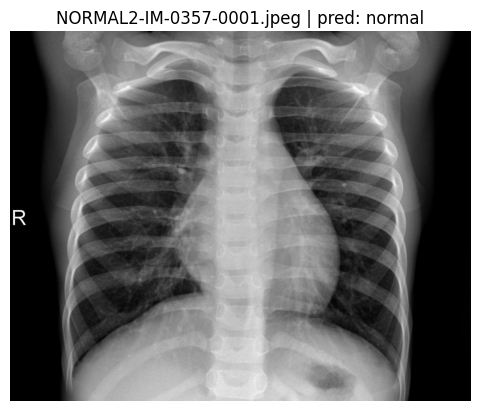

In [ ]:
import sys, base64, json, joblib, random, glob
import matplotlib.pyplot as plt
import cv2

# Limpia caché y apunta al inference correcto
sys.modules.pop("inference", None)
sys.path.insert(0, "/content/code")
from inference import input_fn, predict_fn  # model_fn no es necesario si cargas con joblib

# Carga modelo
model = joblib.load("/content/modelos_exportados/log_reg.joblib")  # ajusta nombre si es otro

# Toma una imagen aleatoria del test (NORMAL + PNEUMONIA)
test_root = "/content/drive/MyDrive/12 semestre/Vision Artificial/actividades/Proyecto VA/chest_xray/test"  # ajusta si tu ruta es distinta
all_files = []
for cls in ["NORMAL", "PNEUMONIA"]:
    all_files += glob.glob(f"{test_root}/{cls}/*.jpeg") + glob.glob(f"{test_root}/{cls}/*.jpg") + glob.glob(f"{test_root}/{cls}/*.png")
assert all_files, "No se encontraron imágenes en test"
img_path = random.choice(all_files)

# Convierte a base64 y predice
with open(img_path, "rb") as f:
    b64_img = base64.b64encode(f.read()).decode("utf-8")
img = input_fn(json.dumps({"image": b64_img}), "application/json")
res = predict_fn(img, model)

# Muestra nombre y predicción
print(f"Archivo: {img_path}")
print("Predicción:", res)

# Muestra la imagen
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title(f"{img_path.split('/')[-1]} | pred: {res['label']}")
plt.axis("off")
plt.show()


In [ ]:
import os
import random
import shutil

# Define source and destination directories
test_source_root = "/content/drive/MyDrive/12 semestre/Vision Artificial/actividades/Proyecto VA/chest_xray/test"
sampled_test_dest = "/content/test"

# Number of samples per class
num_samples_per_class = 30

# Create destination directories if they don't exist
os.makedirs(os.path.join(sampled_test_dest, "NORMAL"), exist_ok=True)
os.makedirs(os.path.join(sampled_test_dest, "PNEUMONIA"), exist_ok=True)

print(f"Sampling {num_samples_per_class} images from each class (NORMAL and PNEUMONIA) from the test set...")

for class_name in ["NORMAL", "PNEUMONIA"]:
    source_class_dir = os.path.join(test_source_root, class_name)
    dest_class_dir = os.path.join(sampled_test_dest, class_name)

    # Get all image files for the current class
    all_class_files = [f for f in os.listdir(source_class_dir) if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

    # Ensure we have enough files to sample
    if len(all_class_files) < num_samples_per_class:
        print(f"Warning: Only {len(all_class_files)} images found for {class_name}. Sampling all available.")
        sampled_files = all_class_files
    else:
        # Randomly sample files
        sampled_files = random.sample(all_class_files, num_samples_per_class)

    # Copy sampled files to the destination directory
    for file_name in sampled_files:
        source_path = os.path.join(source_class_dir, file_name)
        dest_path = os.path.join(dest_class_dir, file_name)
        shutil.copy(source_path, dest_path)
    print(f"Copied {len(sampled_files)} images for class {class_name} to {dest_class_dir}")

print(f"Sampling complete. Sampled test data is available at: {sampled_test_dest}")


Sampling 30 images from each class (NORMAL and PNEUMONIA) from the test set...
Copied 30 images for class NORMAL to /content/test/NORMAL
Copied 30 images for class PNEUMONIA to /content/test/PNEUMONIA
Sampling complete. Sampled test data is available at: /content/test


In [ ]:
import shutil
from google.colab import files
import os

# Define the directory to be downloaded
directory_to_download = "/content/test"

# Define the name for the zip file
zip_filename = "sampled_test_data.zip"

# Create a zip archive of the directory
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', directory_to_download)

# Check if the zip file was created
if os.path.exists(zip_filename):
    print(f"'{directory_to_download}' has been zipped to '{zip_filename}'.")
    # Offer the zip file for download
    files.download(zip_filename)
else:
    print(f"Error: The zip file '{zip_filename}' was not created.")


'/content/test' has been zipped to 'sampled_test_data.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Registro de dependencias y freeze (ejecutar tras entrenar y antes de empaquetar)
Usa esta celda para capturar versiones y generar `requirements_neumonia.txt` que acompañará al `model.tar.gz` en SageMaker.


In [ ]:

import importlib
import json
import platform
import subprocess
import sys

def pkg_version(name):
    try:
        return importlib.import_module(name).__version__
    except Exception:
        return "no encontrado"

summary = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "packages": {
        "numpy": pkg_version("numpy"),
        "pandas": pkg_version("pandas"),
        "scikit-learn": pkg_version("sklearn"),
        "opencv-python": pkg_version("cv2"),
        "Pillow": pkg_version("PIL"),
        "matplotlib": pkg_version("matplotlib"),
        "joblib": pkg_version("joblib"),
    },
}

freeze_output = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
with open("requirements_neumonia.txt", "w", encoding="utf-8") as f:
    f.write(freeze_output)

print(json.dumps(summary, indent=2, ensure_ascii=False))
print("Archivo requirements_neumonia.txt generado en el directorio actual")
